In [1]:
import pandas as pd
import gensim.downloader as api
from gensim.models import KeyedVectors
from gensim.models import KeyedVectors, Word2Vec, phrases
from gensim.parsing import preprocessing
from gensim.parsing.preprocessing import strip_tags, strip_punctuation,strip_numeric,remove_stopwords
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from os import walk
from os import listdir
from os.path import isfile, join

from pprint import pprint

import pickle

from matplotlib import pyplot as plt

import numpy as np
import seaborn as sns
import matplotlib.colors as mcolors
import re

In [2]:
#  Clean data
def text_cleaning(data, label_data):
    new_sentences = []
    filters = [lambda x: x.lower(), strip_tags, strip_punctuation,strip_numeric,remove_stopwords]
    excluded = ['breast', 'cancer', 'survivorship', 'born', 'alive', 'live', 'die', 'died', 'haven', 'have',
                 'area','state' ]
    orig_data = []
    for i in range(data.shape[0]):
        label = label_data.iloc[i]
        if int(label) ==1:
            txt = data.iloc[i]
            orig_data.append(txt)
            txt = txt.lower()
            txt = re.sub("(#.*?)[\s]"," ",txt) # remove all # from tweets
            txt = re.sub("breastcancer"," ",txt)

            c_words = []
            words = preprocessing.preprocess_string(txt, filters)
            for w in words:
                if len(w)>3 and w not in excluded:
                    c_words.append(w)

            new_sentences.append(c_words)
            
    
    return np.asarray(new_sentences), np.asarray(orig_data)

In [3]:
# original data
data = pd.read_csv("breast_cancer.csv")['Text']
label = pd.read_csv("breast_cancer.csv")['Class']
sentences_bcancer,original_bcancer = text_cleaning(data,label)
original_bcancer[0]

"When people who don't know me try to educate me on what a breast cancer patient goes through..."

In [4]:
# create best Bigrams of tweets(calculated based on how often words come together in all tweets)
bigram = gensim.models.Phrases(sentences_bcancer) 
bigram_mod = gensim.models.phrases.Phraser(bigram)
sentences_bcancer = [bigram_mod[doc] for doc in sentences_bcancer]

In [5]:
# original lexicon
data_lexicon = pd.read_csv("brest_cancer_lexicon.csv")['Drug'].to_numpy()
data_lexicox_clean = ["_".join(data.lower().split()) for data in data_lexicon]
data_lexicox_clean[:10]

['chemotherapy',
 'chemo',
 'radiotherapy',
 'evista',
 'raloxifene',
 'hydrochloride',
 'raloxifene_hydrochloride',
 'tamoxifen',
 'citrate',
 'tamoxifen_citrate']

In [6]:
# Load from drug-related w2vec
path_tune = "/Users/thiago/Github/Data/BioW2Vec/DSM-language-model-1B-LARGE/trig-vectors-phrase.bin"
word_vectors = KeyedVectors.load_word2vec_format(path_tune, binary=True, encoding='utf8', unicode_errors='ignore')

In [7]:
# expand original lexion, if not done yet
expand = False
expanded = []
if expand:
    for word in data_lexicox_clean:
        if word in word_vectors:
            expanded.append(word)
            similar = [x[0] for x in word_vectors.most_similar(word,topn=5)]
            expanded.extend(similar)
    
    # save to file
    out = "brest_cancer_lexicon_expanded.csv"
    dict = {'Drug': expanded}   
       
    df = pd.DataFrame(dict) 
    # saving the dataframe  
    df.to_csv(out)  
    print(expanded[0:10])
    

In [8]:
# load expanded lexicon
data_lexicon_expanded = np.unique(pd.read_csv("brest_cancer_lexicon_expanded.csv")['Drug'].to_numpy())

In [9]:
# based on a giving tweet word from user, database of lexicon and ratio
# return a list of all words from user which is misspelled and are breast cancer expression
import Levenshtein
def get_mispelling( w_tweet, database, ratio):
    out = []
    for treatment in database:
        lev_ratio = Levenshtein.ratio(treatment,w_tweet)
        if lev_ratio > ratio:
            out.append(treatment)
    return out

In [17]:
# for each tweet, let's find if tweet has a treatment
#original_bcancer
new_database = []
treatment = []
for index,tweet in enumerate(sentences_bcancer):
    set_words = []
    for word in tweet:
        if word in data_lexicon_expanded and word not in set_words:
            set_words.append(word)
            new_database.append(original_bcancer[index])
            treatment.append(word)
        else:
            mispelled = get_mispelling(word,data_lexicon_expanded, 0.8)
            if len(mispelled) >0:
                for term in mispelled: # add tweet multiple times if have more than 1 treatment
                    term not in set_words
                    set_words.append(term)
                    new_database.append(original_bcancer[index])
                    treatment.append(term)
                    


In [11]:
# Clean a little, to group more treatments - less sparse
treatment_clean = []
for t in treatment:
    if "chemo" in t or "radio" in t:
        treatment_clean.append("chemotherapy")
    elif "letrazol" in t:
        treatment_clean.append("letrazol")
    else:
        treatment_clean.append(t)

In [12]:
# save new dataset
out = "brest_cancer_by_treatments.csv"
dict = {'Tweet': new_database, "Treatment":treatment_clean }   

df = pd.DataFrame(dict) 
# saving the dataframe  
df.to_csv(out)  


In [13]:
# plot distributions
def plot(scores, xpos='center', y_labels ='Total of apperances amoung tweets', 
    title = 'Distribution Tweets per Treatments',
    x_labels = ('Treaments'), label="Treatment"):

  ind = np.arange(len(scores))  # the x locations for the groups
  width = 0.4  # the width of the bars
  fig, ax = plt.subplots()
  rects = ax.bar(ind - width/2, scores, width, label=label)

  # Add some text for labels, title and custom x-axis tick labels, etc.
  ax.set_ylabel(y_labels)
  ax.set_title(title)
  ax.set_xticks(ind)
  ax.set_xticklabels(x_labels)
  #ax.set_xtickrotation(rotation=90)
  plt.xticks(rotation=90)
  ax.legend()

  ha = {'center': 'center', 'right': 'left', 'left': 'right'}
  offset = {'center': 0, 'right': 1, 'left': -1}

  for rect in rects:
    height = rect.get_height() 
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(offset[xpos]*0.5, 0.5),  # use 3 points offset
                textcoords="offset points",  # in both directions
                ha=ha[xpos], va='bottom')

  fig.tight_layout()
  plt.show()

In [14]:
treatment_clean = np.array(treatment_clean)
unique, counts = np.unique(treatment_clean, return_counts=True)
frequencies = np.asarray(( counts,unique,)).T

In [15]:
dist = []
for i in range(counts.shape[0]):
    dist.append((counts[i], unique[i]))
dist.sort(reverse=True)

dist_score = [x[0] for x in dist]
dist_label = [x[1] for x in dist]

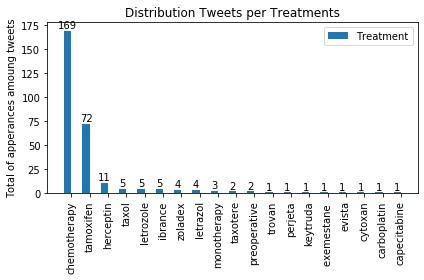

In [16]:
plot(dist_score[:20],x_labels=dist_label[:20])